# Twitter Sentiment Analysis with DistilBERT

## 1. Introduction

**Overview of the Problem:**  
Social media platforms like Twitter generate huge amounts of data every day. Tweets often express opinions, emotions, or reactions to events. Analyzing these sentiments can help businesses, researchers, and policymakers understand public opinion, track brand reputation, and monitor trends in real time.

**Why Sentiment Analysis is Useful:**  
- Helps companies understand customer satisfaction.  
- Monitors public reactions to events or campaigns.  
- Detects positive, negative, and neutral opinions automatically.  
- Useful for decision-making and trend analysis.

**What is DistilBERT and Why We Use It:**  
DistilBERT is a **smaller, faster, and lighter version of BERT**, designed to retain most of BERT’s accuracy while being more efficient.  
- Pretrained on large text corpora, so it understands language patterns.  
- Excellent for **text classification tasks**, including sentiment analysis.  
- Faster to train and deploy compared to full BERT, which is perfect for practical projects.

In [31]:
# !pip install transformers
# !pip install sentencepiece
# !pip install gradio

# Basic imports and environment setup
import json
from pathlib import Path
import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# For NLP and Transformers
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2 Data Collection & Cleaning (Sentiment140)

We will use the **Sentiment140** dataset, which contains **1.6 million labeled tweets**.  
Columns include:
- `target` → sentiment label  
  - `0` = negative  
  - `4` = positive  
- `text` → the tweet content

We will:
- Load the dataset  
- Map labels to 0 (negative) and 1 (positive)  
- Inspect the data  
- Clean the tweets (remove URLs, mentions, hashtags, emojis, special characters)
- Prepare a clean `clean_text` column for modeling


In [2]:
# Load Sentiment140 dataset
df = pd.read_csv("sentiment140.csv", encoding="latin-1", header=None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Map labels: 0 = negative, 4 = positive → 0 and 1
df['target'] = df['target'].map({0: 0, 4: 1})

# Inspect dataset
df.info()
df['target'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


target
0    800000
1    800000
Name: count, dtype: int64

### 2.1 Cleaning Tweets
Removes:
- URLs
- Mentions
- Hashtags
- Emojis
- Non-alphanumeric characters
- Extra spaces
- Converts text to lowercase

In [3]:
def clean_tweet(text):
    text = str(text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove mentions (@user)
    text = re.sub(r"@\w+", "", text)

    # Remove hashtags (#topic)
    text = re.sub(r"#\w+", "", text)

    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r"", text)

    # Remove punctuation
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)

    # Lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

### 2.2 Appply Cleaning

In [4]:
df['clean_text'] = df['text'].apply(clean_tweet)
df[['text', 'clean_text']].head()

,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",a thats a bummer you shoulda got david carr of...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...


## 3. Train / Validation / Test Split

We will split the cleaned dataset into three sets:

- **Training set:** Used to train the model  
- **Validation set:** Used to tune hyperparameters and monitor overfitting  
- **Test set:** Used to evaluate final model performance

We will use an **80/10/10 split** for training/validation/test.

In [5]:
# Only keep relevant columns
df_model = df[['clean_text', 'target']]

# Split into train + temp (90% train+val, 10% test)
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df_model['clean_text'], df_model['target'], test_size=0.1, random_state=42, stratify=df_model['target']
)

# Split train_val into train (80%) and validation (10%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.1111, random_state=42, stratify=train_val_labels
)

# Verify sizes
print("Training samples:", len(train_texts))
print("Validation samples:", len(val_texts))
print("Test samples:", len(test_texts))

Training samples: 1280016
Validation samples: 159984
Test samples: 160000


### 3.1 Verify Label Distribution

We want to ensure the positive/negative labels are balanced across splits.

In [6]:
print("Training set label counts:")
print(pd.Series(train_labels).value_counts(normalize=True))

print("\nValidation set label counts:")
print(pd.Series(val_labels).value_counts(normalize=True))

print("\nTest set label counts:")
print(pd.Series(test_labels).value_counts(normalize=True))

Training set label counts:
target
1    0.5
0    0.5
Name: proportion, dtype: float64

Validation set label counts:
target
1    0.5
0    0.5
Name: proportion, dtype: float64

Test set label counts:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


## 4. Tokenization & PyTorch Dataset Preparation

We will use **DistilBERT tokenizer** to convert tweets into token IDs and attention masks.  

Steps:
1. Load the DistilBERT tokenizer from HuggingFace Transformers.
2. Tokenize and encode the cleaned tweets.
3. Create a **custom PyTorch Dataset**.
4. Prepare **DataLoaders** for training, validation, and test sets.

### 4.1 Load DistilBERT Tokenizer

We will use `DistilBertTokenizerFast` with the base uncased model.

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

### 4.2 Tokenize Tweets

We will:
- Truncate or pad sequences to a **maximum length of 128 tokens**
- Return PyTorch tensors directly for input IDs and attention masks

In [8]:
max_len = 128  # maximum token length

# Tokenize training set
train_encodings = tokenizer(
    list(train_texts), 
    truncation=True, 
    padding=True, 
    max_length=max_len, 
    return_tensors='pt'
)

# Tokenize validation set
val_encodings = tokenizer(
    list(val_texts), 
    truncation=True, 
    padding=True, 
    max_length=max_len, 
    return_tensors='pt'
)

# Tokenize test set
test_encodings = tokenizer(
    list(test_texts), 
    truncation=True, 
    padding=True, 
    max_length=max_len, 
    return_tensors='pt'
)

### 4.3 Custom PyTorch Dataset

We will create a Dataset class to return input IDs, attention masks, and labels for each sample.

In [9]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

### 4.4 Create Dataset Instances

In [10]:
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

### 4.5 DataLoaders

We will use DataLoaders to efficiently load data in batches during training.

In [11]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 5 Model Setup & Training

We will fine-tune **DistilBERT** for binary sentiment classification.

Steps:
1. Load the pretrained `DistilBertForSequenceClassification` model with **2 output labels**.
2. Define the **optimizer** and **loss function**.
3. Set up **training loop** for multiple epochs.
4. Monitor **training and validation loss** for early stopping.

### 5.1 Load DistilBERT for Sequence Classification

In [12]:
# Load pretrained DistilBERT model with 2 output labels
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device:", device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


### 5.2 Optimizer & Loss Function

- Use **AdamW** optimizer (recommended for Transformers)
- Use **CrossEntropyLoss** for binary classification

In [13]:
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

### 5.3 Training Loop

We will:
- Train for multiple epochs
- Track training loss
- Evaluate on validation set each epoch

In [14]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=3):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(train_loader, leave=False)
        for batch in loop:
            optimizer.zero_grad()

            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Average Training Loss: {avg_loss:.4f}")

        # Validation
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f}\n")
        model.train()

### 5.4 Train the Model

In [15]:
# Train for 3 epochs
train_model(model, train_loader, val_loader, optimizer, criterion, epochs=3)

Epoch 1 Average Training Loss: 0.3706
Epoch 1 Validation Loss: 0.3525



Epoch 2 Average Training Loss: 0.3255
Epoch 2 Validation Loss: 0.3490



Epoch 3 Average Training Loss: 0.2922
Epoch 3 Validation Loss: 0.3587



## 6. Model Evaluation

Now that the DistilBERT model has been trained on the Sentiment140 dataset, we evaluate its performance on the **held-out test set**.

We will compute:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **Confusion Matrix**

This helps verify how well the model generalizes to unseen tweets.

In [18]:
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]     # probability of positive class
        preds = torch.argmax(logits, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

### 6.1 Classification report

In [19]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8268    0.8786    0.8519     80000
           1     0.8705    0.8160    0.8423     80000

    accuracy                         0.8473    160000
   macro avg     0.8486    0.8473    0.8471    160000
weighted avg     0.8486    0.8473    0.8471    160000



### 6.2 Accuracy

In [20]:
accuracy = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8472625


### 6.3 Confusion Matrix

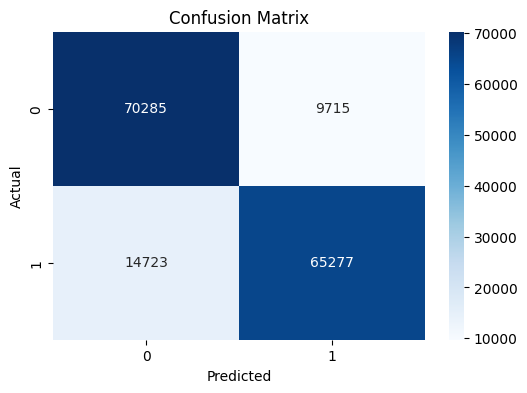

In [22]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 7. Threshold Tuning

By default, sentiment classification uses a threshold of **0.5**:

- If probability ≥ 0.5 → Predict *positive*
- If probability < 0.5 → Predict *negative*

However, this default threshold is not always optimal.  
To improve **precision, recall, or F1-score**, we sweep across a range of thresholds (0.1 → 0.9) and select the threshold that gives the best **F1-score**.

This helps the model perform better on real-world data where mistakes may carry different costs.

### 7.1 Threshold Sweep

In [24]:
thresholds = np.linspace(0.1, 0.9, 17)  # 0.1, 0.15, ..., 0.9
best_threshold = 0.5
best_f1 = 0

for th in thresholds:
    preds_th = (all_probs >= th).astype(int)
    f1 = f1_score(all_labels, preds_th)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = th

print("Best threshold:", best_threshold)
print("Best F1-score:", best_f1)

Best threshold: 0.35
Best F1-score: 0.8504251395321943


In [25]:
preds_best = (all_probs >= best_threshold).astype(int)
print("Classification Report with Best Threshold:", best_threshold)
print(classification_report(all_labels, preds_best, digits=4))

Classification Report with Best Threshold: 0.35
              precision    recall  f1-score   support

           0     0.8661    0.8195    0.8422     80000
           1     0.8287    0.8733    0.8504     80000

    accuracy                         0.8464    160000
   macro avg     0.8474    0.8464    0.8463    160000
weighted avg     0.8474    0.8464    0.8463    160000



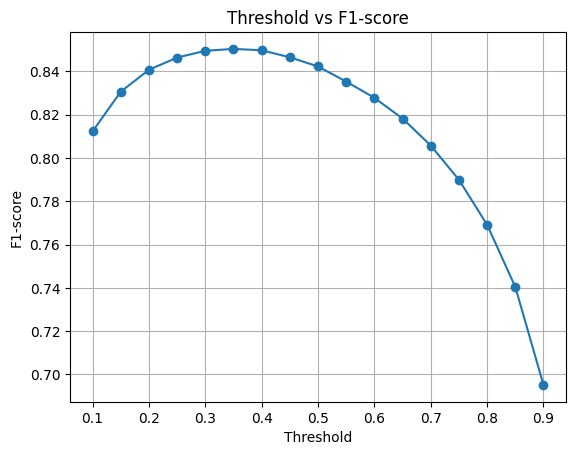

In [26]:
f1_scores = [f1_score(all_labels, (all_probs >= th).astype(int)) for th in thresholds]

plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Threshold vs F1-score")
plt.grid(True)
plt.show()

## 8. Save Final Model and Threshold

After training, evaluation, and threshold tuning, we save the **model, tokenizer, and best threshold**.  
This ensures that the version we deploy or use for inference is the **final, optimized setup**.

In [28]:
save_dir = Path("distilbert_sentiment_model_final")
save_dir.mkdir(exist_ok=True)

# 1. Save model
model.save_pretrained(save_dir)

# 2. Save tokenizer
tokenizer.save_pretrained(save_dir)

# 3. Save best threshold
threshold_path = save_dir / "best_threshold.json"
with open(threshold_path, "w") as f:
    json.dump({"best_threshold": best_threshold}, f)

print(f"Model, tokenizer, and threshold saved to: {save_dir}")

Model, tokenizer, and threshold saved to: distilbert_sentiment_model_final


## 9. Gradio Deployment

We will create a simple web interface using **Gradio** where users can input a tweet and get:

- The predicted sentiment (Positive / Negative)  
- The probability of being positive  

This allows quick testing and sharing without retraining the model.

### 9.1 Load model
We load:

- Gradio for the interface
- PyTorch and HuggingFace for the model
- The saved model, tokenizer, and best threshold

In [32]:
# Load saved model, tokenizer, and threshold
model_dir = "distilbert_sentiment_model_final"
model = DistilBertForSequenceClassification.from_pretrained(model_dir)
model.to(device)
model.eval()

tokenizer = DistilBertTokenizerFast.from_pretrained(model_dir)

with open(f"{model_dir}/best_threshold.json") as f:
    best_threshold = json.load(f)["best_threshold"]

print("Loaded model and threshold:", best_threshold)

Loaded model and threshold: 0.35


### 9.2 Define Prediction Function

This function takes a tweet as input and returns:

- Predicted sentiment label (Positive / Negative)
- Probability of being positive

The function:

1. Cleans the tweet
2. Tokenizes it
3. Runs it through the model
4. Applies the best threshold

In [33]:
def predict_sentiment(tweet):
    # Clean / preprocess tweet (using your existing clean_tweet function)
    clean_text = clean_tweet(tweet)

    # Tokenize
    inputs = tokenizer(
        clean_text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        positive_prob = probs[0, 1].item()
    
    # Apply threshold
    label = "Positive" if positive_prob >= best_threshold else "Negative"
    
    return label, round(positive_prob, 4)

### 9.3 Create Gradio Interface

We define the user interface:

- Input: Textbox for a single tweet
- Outputs: 
  - Label (Predicted Sentiment)
  - Textbox (Probability of Positive)
- Title and description for clarity

In [34]:
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=2, placeholder="Enter a tweet here..."),
    outputs=[
        gr.Label(num_top_classes=1, label="Predicted Sentiment"),
        gr.Textbox(label="Positive Probability")
    ],
    title="Twitter Sentiment Analysis (DistilBERT)",
    description="Enter a tweet to see the predicted sentiment and probability."
)

### 9.4 Launch the Gradio App

We launch the web interface locally.  
Optionally, you can share the app with a public link by setting `share=True`.

In [35]:
# Launch the web app
interface.launch()
# Optional: interface.launch(share=True) to get a public link

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
